In [1]:
%matplotlib inline
from warnings import filterwarnings

# suppressing the multitude of future and user warnings from the graphics libraries
filterwarnings("ignore", category=Warning)

import os, itertools, glob, json, shutil, operator
from itertools import permutations, combinations
import pandas as pd
from plotnine import *
import numpy as np
from cogent3 import LoadTable, DNA
from collections import defaultdict, OrderedDict
#from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter, MultipleLocator
from mutation_motif import util, logo
from mutation_motif.mutation_analysis import get_single_position_fig, single_position_effects, get_selected_indices
from mutation_motif.height import get_re_char_heights
from mutation_motif.draw import get_plot_data, format_float, draw_spectrum_grid

In [2]:
def get_auc(directory, sample_aucs, clf):
    """return the average classification auROC score in specified directory"""
    data_files = glob.glob(os.path.join(directory + 'sample_*/%s/classification_report.json' % clf))
    train_size = int(directory.split('/')[-2].split('_')[-1])
    dimension = int(directory.split('/')[-3].split('_')[0])
    
    for file in data_files:
        json_data=open(file).read()
        data = json.loads(json_data)
        #sample_idx = file.split('/')[7]
        auc_score = data["auROC"]
        sample_aucs.append([dimension, train_size, auc_score, clf])
     
    return sample_aucs

def format_positions(positions):
    positions = positions.split(":")
    old_new = {"0": "-2", "1": "-1", "2": "+1", "3": "+2"}
    redone = [old_new[p[-1]] for p in positions]
    if len(redone) == 1:
        template = "%s"
    else:
        template = "(%s)"
    
    return template % ", ".join(redone)

def format_direction(direction):
    direction = direction.replace('to', r'$\rightarrow$')
    return direction

def format_group(group):
    group_dict = {'ENU_variants':'ENU', 'germline_variants':'Spontaneous'}
    group = group.split('/')[7]
    return group_dict[group]

def format_pvalue(value):
    """0.0 if 0, float if <= 0.0001, scientific otherwise"""
    epsilon = 1e-6
    if value <= 1e-100:
        result = "0.0"
    elif 1-epsilon <= value <= 1.0+epsilon:
        result = "1.0"
    elif 1e-4 <= value:
        result = "%.4f" % value
    elif 0 < value < 1e-4:
        result = latex_format_numbers(value)
    else:
        raise ValueError(value)
    return result

def latex_format_numbers(value):
    try:
        value = float(value)
    except ValueError:
        return value
    
    if value == 0:
        return "0"
    v = "%.1e" % value
    v = v.split("e")
    v[1] = str(int(v[1]))
    v = r"$%s\times 10^{%s}$" % tuple(v)
    return v

table_template = "\\begin{table}[htp]\n\\centering\n%s\n\end{table}\n"

def format_latex_table(table, justify, label=None):
    caption = table.title or ""
    label = label or ""
    table.Title = ""
    result = table_template % table.tostring(format="latex", justify=justify)
    result = result.replace("longtable", "tabular").replace("[htp!]", "")
    
    if caption:
        caption = r"\caption{%s}" % caption
    
    if label:
        caption += r"\label{%s}" % label
    
    if caption:
        result = result.splitlines()
        result.insert(-1, caption)
        result = "\n".join(result)
    
    return result

model_nm_dict = {0:"M", 1:"M+I", 2:"M+I+2D", 3:"M+I+3D", 4:"M+I+4D", 5:"M+I+5D", 6:"FS"}

#### Create a directory `mutation_classifier/figs_n_tabs/`

Assumes this notebook is in the sister directory, `mutation_classifier/scripts`

In [3]:
!mkdir -p figs_n_tabs

# Manuscript figures and tables

In [4]:
all_ms_tables = []

## Figures 

### Figure: mutation motif analysis of neighbourhood effects, figure showing ENU, spontaneous 

In [5]:
!mutation_draw grid --fig_config loglin/scripts/logo_grid_draw.cfg --figpath figs_n_tabs/mm_ENU_v_germline.pdf --format pdf
!rm figs_n_tabs/mm_ENU_v_germline.log
print("figs_n_tabs/mm_ENU_v_germline.pdf is saved.")

2 1
Wrote /Users/gavin/repos/ENUProject/figs_n_tabs/mm_ENU_v_germline.pdf
figs_n_tabs/mm_ENU_v_germline.pdf is saved.


## Table: summary of hypotheses testing comparing the two groups

In [6]:
fns = !ls loglin/results/ENU_vs_germline/autosomes/directions/AtoG/summary.txt
tab_enu_v_sp = LoadTable(fns[0], sep="\t")
tab_enu_v_sp = tab_enu_v_sp.with_new_column("Position(s)", format_positions, columns=["Position"])
tab_enu_v_sp = tab_enu_v_sp.get_columns(["Position(s)", "Deviance", "df", "prob"])
tab_enu_v_sp = tab_enu_v_sp.with_new_header("prob", "p-value")
tab_enu_v_sp.format_column("p-value", format_pvalue)
tab_enu_v_sp.format_column("Deviance", "%.1f")
tab_enu_v_sp = tab_enu_v_sp.sorted(columns=["df", "Deviance"])

tab_enu_v_sp.legend = r"Log-linear analysis of mutation motif comparison between mouse germline and ENU-induced "\
+r"A$\rightarrow$G mutations. Deviance is from the log-linear model, with df degrees-of-freedom"\
+r"and corresponding p-value obtained from the $\chi^2$ distribution. p-values below 0.025 are "\
+r"determined to be significant."

print (tab_enu_v_sp)
all_ms_tables.append(format_latex_table(tab_enu_v_sp, justify="rrrl", label="table:enu_v_germline:a-g"))

     Position(s)    Deviance    df                 p-value
----------------------------------------------------------
              +2        88.6     3    $4.4\times 10^{-19}$
              -2      1105.6     3                     0.0
              +1      1393.7     3                     0.0
              -1      5693.3     3                     0.0
        (-2, +2)        12.0     9                  0.2145
        (-1, +2)        50.3     9     $9.4\times 10^{-8}$
        (+1, +2)        96.1     9    $9.5\times 10^{-17}$
        (-2, +1)       123.0     9    $3.3\times 10^{-22}$
        (-2, -1)       284.1     9    $6.2\times 10^{-56}$
        (-1, +1)       353.1     9    $1.3\times 10^{-70}$
    (-2, -1, +2)        41.2    27                  0.0396
    (-1, +1, +2)        46.9    27                  0.0100
    (-2, +1, +2)        55.1    27                  0.0011
    (-2, -1, +1)        62.2    27                  0.0001
(-2, -1, +1, +2)       118.6    81                  0.00

## Figure: 7-mer learning curve indicates M+I+2D is sufficient

figs_n_tabs/7mer_learning_curve.pdf is saved!


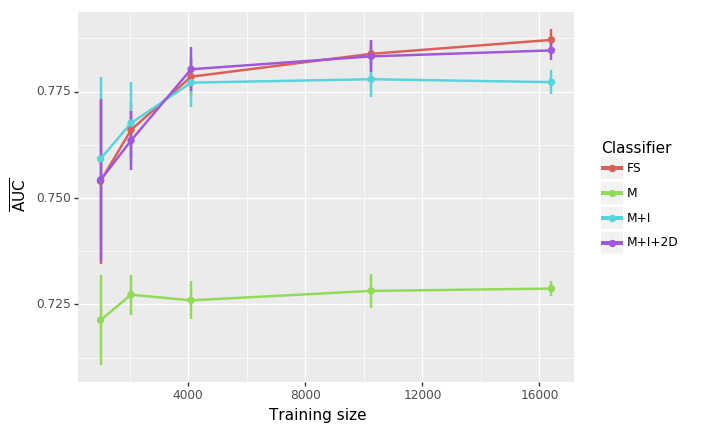

<ggplot: (285359599)>


In [7]:
lc_aucs_7mer = []
dims = [0,1,2,6]    

for dim in dims:
    data_dirs = glob.glob("classifier/results/chrom1/7-mer/data_ratio_1/direction_All/%s_way_samples/train_size_*/" % dim)
    
    sample_aucs = []
    for directory in data_dirs:
        aucs = get_auc(directory, sample_aucs, 'LR')
    sort_aucs = sorted(sample_aucs, key = lambda x: int(x[1]))
    for r in sort_aucs:
        dim = r[0]
        train_size = r[1]
        auc = float(r[2])
        lc_aucs_7mer.append([model_nm_dict[dim], train_size, auc])

models = set(r[0] for r in lc_aucs_7mer)
train_sizes = set(r[1] for r in lc_aucs_7mer)
n = 5

lc_auc_records = []
for model in models:
    for train_size in train_sizes:
        auc_list = []
        for r in lc_aucs_7mer:
            if model not in r:
                continue
            if train_size not in r:
                continue
            auc_list.append(r[2])
            
        auc_mean = np.array(auc_list).mean()
        auc_se = np.array(auc_list).std(ddof=1)
        
        lc_auc_records.append([model, train_size, auc_mean, auc_se]) 

h = ['Classifier', 'Training_size', 'Mean_AUC', 'Std_error']
lc_tab = LoadTable(header=h, rows=lc_auc_records).to_pandas_df()
lc_fig = (ggplot(lc_tab) +
     aes(x="Training_size", y="Mean_AUC", colour="Classifier") +
     geom_errorbar(aes(ymin="Mean_AUC-Std_error", ymax="Mean_AUC+Std_error"), width=.1, size=1) +
     geom_line(size=1) +
     geom_point(size=2) +
     labs(x="Training size", y="$\overline{\mathrm{AUC}}$")
       )

outname = "figs_n_tabs/7mer_learning_curve.pdf"
lc_fig.save(outname, units="cm", width=20, height=16)
print ("%s is saved!" % outname)
print (lc_fig)       

## Figure: faceted plot comparing mean AUC between k-mer samples

figs_n_tabs/kmer_comparison.pdf is saved!


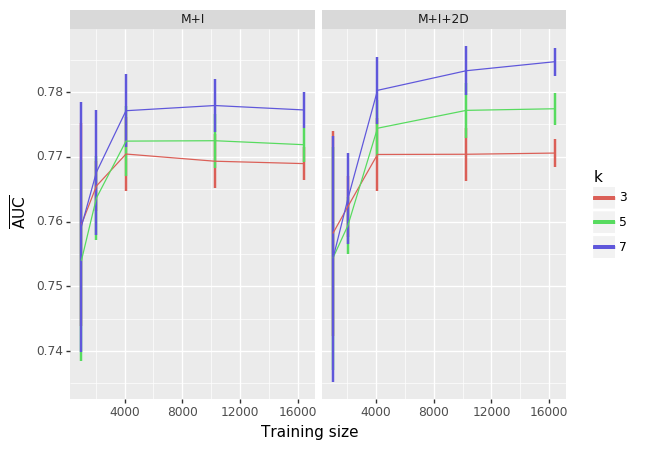

<ggplot: (286130629)>


In [8]:
window_sizes = [3, 5, 7]
dims = [0, 1, 2]
train_sizes = [1009, 2050, 4101, 10255, 16408]

plot_rows = []
for dim in dims:
    for ws in window_sizes:
        for ts in train_sizes:
            data_dirs = glob.glob("classifier/results/chrom1/%s-mer/data_ratio_1/direction_All/%s_way_samples/train_size_%s/" % (ws, dim, ts))
            for directory in data_dirs:
                aucs = get_auc(directory, [], 'LR')
                auc_list = [r[2] for r in aucs]
                auc_mean = np.array(auc_list).mean()
                auc_se = np.array(auc_list).std(ddof=1)
                model_name = model_nm_dict[dim]
                if model_name == "M":
                    continue  # we ignore this since the results are identical for all k
                plot_rows.append([model_name, '%s' % ws, ts, auc_mean, auc_se])

plot_header = ['Classifier_design', 'k', 'Train_size', 'Mean_AUC', 'Std_error']
faceted_tab = LoadTable(header=plot_header, rows=plot_rows).to_pandas_df()
faceted_plot = (ggplot(faceted_tab) +
                aes(x='Train_size', y='Mean_AUC', colour='k', group='k') + 
                geom_errorbar(aes(ymin="Mean_AUC-Std_error", ymax="Mean_AUC+Std_error"), width=.1, size=1) +
                geom_line() + 
                labs(x="Training size", y="$\overline{\mathrm{AUC}}$") +
                facet_wrap(' ~ Classifier_design')
               )

outname = "figs_n_tabs/kmer_comparison.pdf"
faceted_plot.save(outname, units="cm", width=20, height=9)
print ("%s is saved!" % outname)
print (faceted_plot)

## Figure: Bar chart showing distributions of LR AUC from all chromosomes using M+I+2D with window size of 7 bp

figs_n_tabs/all_lr_aucs_bars.pdf is saved!


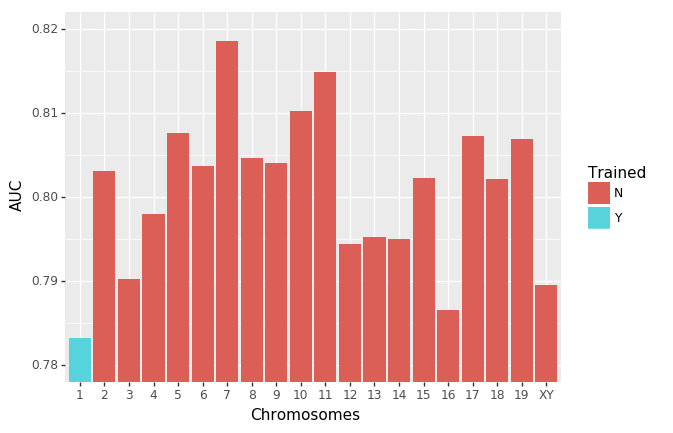

<ggplot: (286431559)>


In [9]:
all_chroms = [1, 2, 3, 4, 5, 6, 7, 8, 9,10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 'XY']

bar_chart_records = []
for chrom in all_chroms:
    if chrom is 1:
        data_dirs = glob.glob("classifier/results/chrom1/7-mer/data_ratio_1/direction_All/2_way_samples/train_size_10255/")
        trained = 'Y'
    else:
        data_dirs = glob.glob("classifier/results/chrom%s/7-mer/data_ratio_1/direction_All/2_way_samples/train_size_0/" % chrom)
        trained = 'N'
    sample_aucs = []
    for directory in data_dirs:
        aucs = get_auc(directory, sample_aucs, 'LR')
    auc_list = [r[2] for r in aucs]
    auc_mean = np.array(auc_list).mean()
    #auc_se = np.array(auc_list).std(ddof=1)
    bar_chart_records.append([auc_mean, chrom, trained, 'LR'])

bar_chart_header = ['AUC_mean', 'Chromosome', 'Trained', 'Classifier']
lr_bar_chart_tab = LoadTable(header=bar_chart_header, rows=bar_chart_records).to_pandas_df().sort_values('AUC_mean')
lr_bar_chart = (ggplot(aes(x='Chromosome', y="AUC_mean", fill="Trained"), data=lr_bar_chart_tab) + \
                labs(x="Chromosomes", y="AUC") + \
                geom_bar(stat="identity") + coord_cartesian(ylim=(0.78, 0.82)) + \
                scale_x_discrete(limit='AUC_mean'))
outname = "figs_n_tabs/all_lr_aucs_bars.pdf"
lr_bar_chart.save(outname, units="cm", width=20, height=16)
print ("%s is saved!" % outname)
print (lr_bar_chart)

## Figure: Bar chart showing one-class classification AUC for all chromosomes using M+I+2D with window size of 7 bp

figs_n_tabs/all_ocs_aucs_bars.pdf is saved!


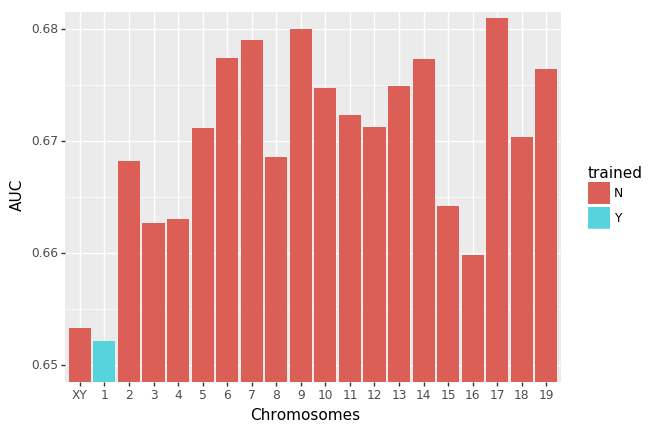

<ggplot: (286682067)>


In [10]:
all_chroms = [1, 2, 3, 4, 5, 6, 7, 8, 9,10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 'XY']

bar_chart_records = []
for chrom in all_chroms:
    if chrom is 1:
        data_dirs = glob.glob("classifier/results/chrom1/7-mer/data_ratio_1/direction_All/2_way_samples/train_size_10255/")
        trained = 'Y'
    else:
        data_dirs = glob.glob("classifier/results/chrom%s/7-mer/data_ratio_1/direction_All/2_way_samples/train_size_0/" % chrom)
        trained = 'N'
    sample_aucs = []
    for directory in data_dirs:
        aucs = get_auc(directory, sample_aucs, 'OCS')
    
    auc_list = [r[2] for r in aucs]
    auc_mean = np.array(auc_list).mean()
    #auc_se = np.array(auc_list).std(ddof=1)
    bar_chart_records.append([auc_mean, chrom, trained, 'OC'])


bar_chart_header = ['AUC_mean', 'Chromosome', 'trained', 'Classifier']
ocs_bar_chart_tab = LoadTable(header=bar_chart_header, rows=bar_chart_records).to_pandas_df()
ocs_bar_chart = (ggplot(aes(x='Chromosome', y="AUC_mean", fill="trained"), data=ocs_bar_chart_tab) + \
             labs(x="Chromosomes", y="AUC") + \
             geom_bar(stat="identity") + coord_cartesian(ylim=(0.65, 0.68))) 

outname = "figs_n_tabs/all_ocs_aucs_bars.pdf"
ocs_bar_chart.save(outname, units="cm", width=20, height=16)
print ("%s is saved!" % outname)
print (ocs_bar_chart)

figs_n_tabs/all_lr_vs_ocs_aucs.pdf is saved!


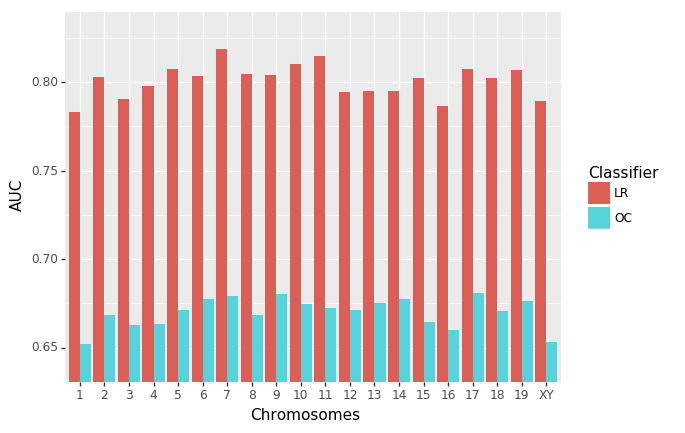

<ggplot: (286428364)>


In [11]:
merged_bar_chart_tab = pd.concat([lr_bar_chart_tab, ocs_bar_chart_tab])
lvo_bar_chart = (ggplot(aes(x='Chromosome', y="AUC_mean", fill="Classifier"), data=merged_bar_chart_tab) + \
             labs(x="Chromosomes", y="AUC") + \
             geom_bar(stat="identity", position = "dodge") + coord_cartesian(ylim=(0.64, 0.83)))

outname = "figs_n_tabs/all_lr_vs_ocs_aucs.pdf"
lvo_bar_chart.save(outname, units="cm", width=20, height=16)
print ("%s is saved!" % outname)
print (lvo_bar_chart)

## Figure: One class classification results summary for 7-mer experiments

figs_n_tabs/oc_learning_curve.pdf is saved!


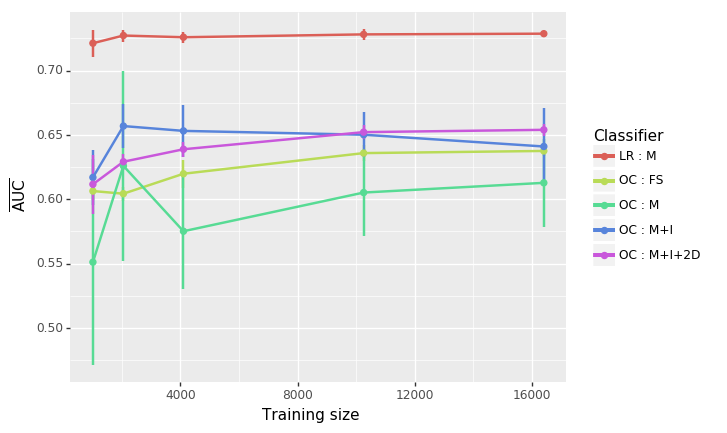

<ggplot: (286666735)>

In [12]:
ocs_aucs_7mer = []
dims = [0,1,2,6]    

for dim in dims:
    data_dirs = glob.glob("classifier/results/chrom1/7-mer/data_ratio_1/direction_All/%s_way_samples/train_size_*/" % dim)
    
    sample_aucs = []
    for directory in data_dirs:
        aucs = get_auc(directory, sample_aucs, 'OCS')
    sort_aucs = sorted(sample_aucs, key = lambda x: int(x[1]))
    for r in sort_aucs:
        dim = r[0]
        train_size = r[1]
        auc = float(r[2])
        ocs_aucs_7mer.append(['OC : %s' % model_nm_dict[dim], train_size, auc])

lr_dirs = glob.glob("classifier/results/chrom1/7-mer/data_ratio_1/direction_All/0_way_samples/train_size_*/")
sample_aucs = []
for lr_dir in lr_dirs:
    lr_aucs = get_auc(lr_dir, sample_aucs, 'LR')
sort_lr_aucs = sorted(sample_aucs, key = lambda x: int(x[1]))
for r in sort_lr_aucs:
    dim = r[0]
    train_size = r[1]
    auc = float(r[2])
    ocs_aucs_7mer.append(['LR : %s' % model_nm_dict[dim], train_size, auc])

models = set(r[0] for r in ocs_aucs_7mer)
train_sizes = set(r[1] for r in ocs_aucs_7mer)
n = 5

lc_auc_records = []
for model in models:
    for train_size in train_sizes:
        auc_list = []
        for r in ocs_aucs_7mer:
            if model not in r:
                continue
            if train_size not in r:
                continue
            auc_list.append(r[2])
            
        auc_mean = np.array(auc_list).mean()
        auc_se = np.array(auc_list).std(ddof=1)
        
        lc_auc_records.append([model, train_size, auc_mean, auc_se]) 

h = ['Classifier', 'Training_size', 'Mean_AUC', 'Std_error']
oc_lc_tab = LoadTable(header=h, rows=lc_auc_records).to_pandas_df()
lc_fig = (ggplot(oc_lc_tab) +
     aes(x="Training_size", y="Mean_AUC", colour="Classifier") +
     geom_errorbar(aes(ymin="Mean_AUC-Std_error", ymax="Mean_AUC+Std_error"), width=.1, size=1) +
     geom_line(size=1) +
     geom_point(size=2) +
     labs(x="Training size", y="$\overline{\mathrm{AUC}}$")
       )

outname = "figs_n_tabs/oc_learning_curve.pdf"
lc_fig.save(outname, units="cm", width=20, height=16)
print ("%s is saved!" % outname)
lc_fig

#### Save all manuscript tables into a .tex file

In [13]:
with open("figs_n_tabs/ms_tables.tex", "w") as out:
    out.write("\n\n".join(all_ms_tables))

# Supplementary figures and tables

In [14]:
all_supp_tables = []

## Supp. table: mutation sample counts summary

In [15]:
chroms = [1, 2, 3, 4, 5, 6, 7, 8, 9,10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 'XY']
enu_size_dict = {1: 16977, 2: 21100, 3: 11228, 4: 13973, 5: 14509, 6: 13039, 7: 20864, 8: 11232, 
                 9: 14010, 10: 11315, 11: 17101, 12: 8022, 13: 9085, 14: 8395, 15: 9342, 16: 7266, 
                 17: 11981, 18: 6356, 19: 7529, 'XY': 853}
sp_sizes_dict = {1: 17848, 2: 20051, 3: 11713, 4: 16936, 5: 16028, 6: 12097, 7: 19161, 8: 13465, 
                 9: 15662, 10: 12641, 11: 19626, 12: 8817, 13: 8939, 14: 8868, 15: 11079, 16: 8117, 
                 17: 12168, 18: 7732, 19: 8635, 'XY': 5097}

rows = []
for chrom in chroms:
    num_enu = enu_size_dict[chrom]
    num_sp = sp_sizes_dict[chrom]
    rows.append([chrom, num_enu, num_sp])

header = ['Chromosome', 'ENU-induced', 'Spontaneous']
all_size_table = LoadTable(header=header, rows=rows)
all_size_table.legend = r"By-chromosome sample sizes of genetic variants from the ENU induced and spontaneous "\
+r"germline mutations."
print (all_size_table)
all_supp_tables.append(format_latex_table(all_size_table, justify="rrrl", label="tab:all_chroms_size_summary"))



Chromosome    ENU-induced    Spontaneous
----------------------------------------
         1          16977          17848
         2          21100          20051
         3          11228          11713
         4          13973          16936
         5          14509          16028
         6          13039          12097
         7          20864          19161
         8          11232          13465
         9          14010          15662
        10          11315          12641
        11          17101          19626
        12           8022           8817
        13           9085           8939
        14           8395           8868
        15           9342          11079
        16           7266           8117
        17          11981          12168
        18           6356           7732
        19           7529           8635
        XY            853           5097
----------------------------------------
By-chromosome sample sizes of genetic variants from the E

## Supp. table: ENU spectra analysis of p-values

In [16]:
fns = !ls loglin/results/ENU_variants/autosomes/directions/AtoG/*.txt
tab_enu = LoadTable(fns[0], sep="\t")
tab_enu = tab_enu.with_new_column("Position(s)", format_positions, columns=["Position"])
tab_enu = tab_enu.get_columns(["Position(s)", "Deviance", "df", "prob"])
tab_enu = tab_enu.with_new_header("prob", "p-value")
tab_enu.format_column("p-value", format_pvalue)
tab_enu.format_column("Deviance", "%.1f")
tab_enu = tab_enu.sorted(columns=["df", "Deviance"])

tab_enu.legend = r"Log-linear analysis of ENU-induced A$\rightarrow$G mutation. "\
+r"Position(s) are relative to the index position. Deviance is from the log-linear model, "\
+r"with df degrees-of-freedom and corresponding p-value obtained from the $\chi^2$ "\
+r"distribution. p-values listed as 0.0 are below the limit of detection. "\
+r"See \citet{zhu2017statistical} for a more detailed description of the log-linear models."
print (tab_enu)
all_supp_tables.append(format_latex_table(tab_enu, justify="rrrl", label="suptable:a-g:enu"))

     Position(s)    Deviance    df                 p-value
----------------------------------------------------------
              +2       654.6     3                     0.0
              -2       858.8     3                     0.0
              -1      6221.4     3                     0.0
              +1      7911.6     3                     0.0
        (-1, +2)        39.6     9     $9.1\times 10^{-6}$
        (-2, +2)        58.9     9     $2.2\times 10^{-9}$
        (+1, +2)       137.1     9    $4.1\times 10^{-25}$
        (-2, +1)       154.0     9    $1.3\times 10^{-28}$
        (-2, -1)       232.4     9    $5.3\times 10^{-45}$
        (-1, +1)       757.2     9                     0.0
    (-2, -1, +2)        36.0    27                  0.1164
    (-2, +1, +2)        51.9    27                  0.0027
    (-1, +1, +2)        95.0    27     $1.7\times 10^{-9}$
    (-2, -1, +1)       108.5    27    $1.0\times 10^{-11}$
(-2, -1, +1, +2)       133.6    81                  0.00

## Supp. table: Neighbourhood effect analysis for spontaneous mutations

In [17]:
fns = !ls loglin/results/germline_variants/autosomes/directions/AtoG/*.txt
tab_spontaneous = LoadTable(fns[0], sep="\t")
tab_spontaneous = tab_spontaneous.with_new_column("Position(s)", format_positions, columns=["Position"])
tab_spontaneous = tab_spontaneous.get_columns(["Position(s)", "Deviance", "df", "prob"])
tab_spontaneous = tab_spontaneous.with_new_header("prob", "p-value")
tab_spontaneous.format_column("p-value", format_pvalue)
tab_spontaneous.format_column("Deviance", "%.1f")
tab_spontaneous = tab_spontaneous.sorted(columns=["df", "Deviance"])

tab_spontaneous.legend = r"Log-linear analysis of germline spontaneous A$\rightarrow$G mutation. "\
+r"Position(s) are relative to the index position. Deviance is from the log-linear model, "\
+r"with df degrees-of-freedom and corresponding p-value obtained from the $\chi^2$ "\
+r"distribution. p-values listed as 0.0 are below the limit of detection. "\
+r"See \citet{zhu2017statistical} for a more detailed description of the log-linear models."
print (tab_spontaneous)
all_supp_tables.append(format_latex_table(tab_spontaneous, justify="rrrl", label="suptable:a-g:germline"))

     Position(s)    Deviance    df                 p-value
----------------------------------------------------------
              +2       130.8     3    $3.6\times 10^{-28}$
              -2       553.2     3                     0.0
              +1      1140.0     3                     0.0
              -1      1447.4     3                     0.0
        (+1, +2)        49.9     9     $1.1\times 10^{-7}$
        (-2, +2)        60.4     9     $1.1\times 10^{-9}$
        (-1, +2)        72.9     9    $4.0\times 10^{-12}$
        (-2, +1)       123.2     9    $3.0\times 10^{-22}$
        (-2, -1)       330.3     9    $9.6\times 10^{-66}$
        (-1, +1)       341.5     9    $4.0\times 10^{-68}$
    (-2, +1, +2)        59.5    27                  0.0003
    (-2, -1, +2)        60.2    27                  0.0002
    (-1, +1, +2)        60.6    27                  0.0002
    (-2, -1, +1)       125.6    27    $1.2\times 10^{-14}$
(-2, -1, +1, +2)       110.8    81                  0.01

## Supp. table: Number of positions showing significant differences between ENU and Spontaneous

In [18]:
fns = !ls loglin/results/ENU_vs_germline/autosomes/directions/*/summary.txt

p_sum_rows = []
for fn in fns:
    start, end = fn.split('/')[-2].split('to')
    mut_dir = start + r'$\rightarrow$' + end
    
    summary_tab = LoadTable(fn, sep="\t")
    p_vals = summary_tab.get_columns(["Position", "prob"]).tolist()
    
    first_p_vals = []
    second_p_vals = []
    third_p_vals = []
    forth_p_vals = []
    for record in p_vals:
        poses = record[0]
        order = poses.count(':') + 1
        if order == 1:
            first_p_vals.append(record[1])
        if order == 2:
            second_p_vals.append(record[1])
        if order == 3:
            third_p_vals.append(record[1])
        if order == 4:
            forth_p_vals.append(record[1])
    
    first_p_num = sum(p < 0.05 for p in first_p_vals)
    second_p_num = sum(p < 0.05 for p in second_p_vals)
    third_p_num = sum(p < 0.05 for p in third_p_vals)
    forth_p_num = sum(p < 0.05 for p in forth_p_vals)
    p_sum_rows.append([mut_dir, first_p_num, second_p_num, third_p_num, forth_p_num])

p_sum_header = ["Mutation direction", "1st-order", "2nd-order", "3rd-order", "4th-order"]
p_sum_tab = LoadTable(header=p_sum_header, rows=p_sum_rows, sep='\t')
p_sum_tab.legend = r"Number of positions showing significant differences between ENU-induced and "\
+r"spontaneous germline poiint mutations from analysis of 5-mers. p-values were "\
+r"from the log-linear analysis."
print (p_sum_tab)
all_supp_tables.append(p_sum_tab.tostring(format="latex", justify="ccccc", label="suptable:p_sum_tab"))

Mutation direction    1st-order    2nd-order    3rd-order    4th-order
----------------------------------------------------------------------
   A$\rightarrow$C            4            5            3            0
   A$\rightarrow$G            4            5            4            1
   A$\rightarrow$T            4            5            2            1
   C$\rightarrow$A            4            6            4            1
   C$\rightarrow$T            4            5            4            1
   G$\rightarrow$A            4            5            4            1
   G$\rightarrow$T            4            5            2            1
   T$\rightarrow$A            4            6            2            0
   T$\rightarrow$C            4            6            4            0
   T$\rightarrow$G            4            5            3            1
----------------------------------------------------------------------
Number of positions showing significant differences between ENU-induced and s

## Supp. table: mutation motif analysis of spectra difference

In [19]:
fns = !ls loglin/results/ENU_vs_germline/autosomes/combined/spectra_summary.txt

tab_spectra = LoadTable(fns[0], sep="\t")
tab_spectra = tab_spectra.get_columns(["direction", "group", "ret"])
tab_spectra = tab_spectra.with_new_header("direction", "Direction")
tab_spectra = tab_spectra.with_new_header("group", "Class")
tab_spectra = tab_spectra.with_new_header("ret", "RET")
tab_spectra.format_column("Direction", format_direction)
tab_spectra.format_column("Class", format_group)
tab_spectra.format_column("RET", "%.3f")
tab_spectra = tab_spectra.sorted(columns=["RET"])

tab_spectra.legend = r"Comparison of mutation spectra between Spontaneous and ENU-induced "\
+r"germline point mutations. RET values are proportional to deviance generated from the log-linear model \citep{zhu2017statistical}, and "\
+r"p-value are obtained from the $\chi^2$ distribution. All p-values were below the limit of detection."
print (tab_spectra)
all_supp_tables.append(format_latex_table(tab_spectra, justify="rrrl", label="suptable:spectra:enu_spontaneous"))

      Direction          Class       RET
----------------------------------------
T$\rightarrow$C            ENU    -0.047
A$\rightarrow$T    Spontaneous    -0.036
G$\rightarrow$T    Spontaneous    -0.036
T$\rightarrow$A    Spontaneous    -0.035
A$\rightarrow$G            ENU    -0.035
C$\rightarrow$A    Spontaneous    -0.034
G$\rightarrow$A            ENU    -0.025
C$\rightarrow$T            ENU    -0.021
A$\rightarrow$C            ENU    -0.018
T$\rightarrow$G            ENU    -0.007
G$\rightarrow$C            ENU    -0.001
C$\rightarrow$G            ENU    -0.001
T$\rightarrow$G    Spontaneous     0.009
C$\rightarrow$G    Spontaneous     0.022
C$\rightarrow$T    Spontaneous     0.022
G$\rightarrow$C    Spontaneous     0.023
G$\rightarrow$A    Spontaneous     0.027
A$\rightarrow$C    Spontaneous     0.027
A$\rightarrow$G    Spontaneous     0.039
C$\rightarrow$A            ENU     0.052
T$\rightarrow$C    Spontaneous     0.055
G$\rightarrow$T            ENU     0.063
T$\rightarrow$A 

## Supp. table: Summarized 3-mer AUC results of different classifiers

In [20]:
lc_aucs_3mer = []
dims = [0,1,2]
train_sizes = [1009, 2050, 4101, 10255, 16408]


for dim in dims:
    for ts in train_sizes:
        data_dirs = glob.glob("classifier/results/chrom1/3-mer/data_ratio_1/direction_All/%s_way_samples/train_size_%s/" % (dim, ts))
        sample_aucs = []
        for directory in data_dirs:
            get_auc(directory, sample_aucs, 'LR')
        sort_aucs = sorted(sample_aucs, key = lambda x: int(x[1]))
        
        aucs = [r[2] for r in sort_aucs]
        max_auc = max(aucs)
        min_auc = min(aucs)
        
        lc_aucs_3mer.append([model_nm_dict[dim], ts, max_auc, min_auc])
    
lc_headers_3mer = ["Classifier design", "Training size", "max AUC", "min AUC"]
lc_3mer = LoadTable(header=lc_headers_3mer, rows=lc_aucs_3mer, digits=3,
                  column_templates={'Training size': "{:,}".format},
                  legend="Summary of AUC scores from LR classifiers using 3-mers.")

print (lc_3mer)
all_supp_tables.append(lc_3mer.tostring(format="latex", justify="rrrc", label="suptable:LR_aucs_3mer"))

Classifier design    Training size    max AUC    min AUC
--------------------------------------------------------
                M            1,009      0.738      0.711
                M            2,050      0.735      0.723
                M            4,101      0.730      0.720
                M           10,255      0.735      0.725
                M           16,408      0.731      0.727
              M+I            1,009      0.777      0.737
              M+I            2,050      0.772      0.763
              M+I            4,101      0.777      0.762
              M+I           10,255      0.775      0.764
              M+I           16,408      0.773      0.766
           M+I+2D            1,009      0.777      0.736
           M+I+2D            2,050      0.767      0.755
           M+I+2D            4,101      0.776      0.763
           M+I+2D           10,255      0.775      0.766
           M+I+2D           16,408      0.774      0.769
-------------------------------

## Supp. table: Summarized 5-mer AUC results of different classifiers

In [21]:
lc_aucs_5mer = []
dims = [0,1,2,4]    
train_sizes = [1009, 2050, 4101, 10255, 16408]

for dim in dims:
    for ts in train_sizes:
        data_dirs = glob.glob("classifier/results/chrom1/5-mer/data_ratio_1/direction_All/%s_way_samples/train_size_%s/" % (dim, ts))
    
        sample_aucs = []
        for directory in data_dirs:
            aucs = get_auc(directory, sample_aucs, 'LR')
        sort_aucs = sorted(sample_aucs, key = lambda x: int(x[1]))
    
        aucs = [r[2] for r in sort_aucs]
        max_auc = max(aucs)
        min_auc = min(aucs)
        
        lc_aucs_5mer.append([model_nm_dict[dim], ts, max_auc, min_auc])

lc_headers_5mer = ["Classifier design", "Training size", "max AUC", "min AUC"]
lc_5mer = LoadTable(header=lc_headers_5mer, rows=lc_aucs_5mer, digits=3,
                  column_templates={'Training size': "{:,}".format},
                  legend="Summary of AUC scores from LR classifiers using 5-mers.")

print (lc_5mer)
all_supp_tables.append(lc_5mer.tostring(format="latex", justify="rrrc", label="suptable:LR_aucs_5mer"))

Classifier design    Training size    max AUC    min AUC
--------------------------------------------------------
                M            1,009      0.738      0.711
                M            2,050      0.735      0.723
                M            4,101      0.730      0.720
                M           10,255      0.735      0.725
                M           16,408      0.731      0.727
              M+I            1,009      0.771      0.736
              M+I            2,050      0.775      0.758
              M+I            4,101      0.779      0.764
              M+I           10,255      0.778      0.768
              M+I           16,408      0.775      0.769
           M+I+2D            1,009      0.774      0.735
           M+I+2D            2,050      0.765      0.755
           M+I+2D            4,101      0.779      0.769
           M+I+2D           10,255      0.781      0.772
           M+I+2D           16,408      0.781      0.775
           M+I+4D            1,

## Supp. table: Summarized 7-mer AUC results of different classifiers

In [22]:
lc_aucs_7mer = []
dims = [0,1,2,6]    
train_sizes = [1009, 2050, 4101, 10255, 16408]

for dim in dims:
    for ts in train_sizes:
        data_dirs = glob.glob("classifier/results/chrom1/7-mer/data_ratio_1/direction_All/%s_way_samples/train_size_%s/" % (dim, ts))
    
        sample_aucs = []
        for directory in data_dirs:
            aucs = get_auc(directory, sample_aucs, 'LR')
        sort_aucs = sorted(sample_aucs, key = lambda x: int(x[1]))
    
        aucs = [r[2] for r in sort_aucs]
        max_auc = max(aucs)
        min_auc = min(aucs)
        lc_aucs_7mer.append([model_nm_dict[dim], ts, max_auc, min_auc])


lc_headers_7mer = ["Classifier design", "Training size", "max AUC", "min AUC"]
lc_7mer = LoadTable(header=lc_headers_7mer, rows=lc_aucs_7mer, digits=3,
                  column_templates={'Training size': "{:,}".format},
                  legend="Summary of AUC scores from LR classifiers using 7-mers.")

print (lc_7mer)
all_supp_tables.append(lc_7mer.tostring(format="latex", justify="rrrc", label="suptable:LR_aucs_7mer"))

Classifier design    Training size    max AUC    min AUC
--------------------------------------------------------
                M            1,009      0.738      0.711
                M            2,050      0.735      0.723
                M            4,101      0.730      0.720
                M           10,255      0.735      0.725
                M           16,408      0.731      0.727
              M+I            1,009      0.781      0.737
              M+I            2,050      0.778      0.755
              M+I            4,101      0.785      0.771
              M+I           10,255      0.784      0.774
              M+I           16,408      0.780      0.774
           M+I+2D            1,009      0.777      0.734
           M+I+2D            2,050      0.771      0.755
           M+I+2D            4,101      0.788      0.775
           M+I+2D           10,255      0.788      0.778
           M+I+2D           16,408      0.787      0.783
               FS            1,

## Supp. table: Summarized 7-mer AUC results of different NB classifiers

In [23]:
lc_aucs_7mer = []
dims = [0,1,2,6]    
train_sizes = [1009, 2050, 4101, 10255, 16408]

for dim in dims:
    for ts in train_sizes:
        data_dirs = glob.glob("classifier/results/chrom1/7-mer/data_ratio_1/direction_All/%s_way_samples/train_size_%s/" % (dim, ts))
    
        sample_aucs = []
        for directory in data_dirs:
            aucs = get_auc(directory, sample_aucs, 'NB')
        sort_aucs = sorted(sample_aucs, key = lambda x: int(x[1]))
    
        aucs = [r[2] for r in sort_aucs]
        max_auc = max(aucs)
        min_auc = min(aucs)
        lc_aucs_7mer.append([model_nm_dict[dim], ts, max_auc, min_auc])


lc_headers_7mer = ["Classifier design", "Training size", "max AUC", "min AUC"]
lc_7mer = LoadTable(header=lc_headers_7mer, rows=lc_aucs_7mer, digits=3,
                  column_templates={'Training size': "{:,}".format},
                  legend="Summary of AUC scores from Na\"ive Bayes classifiers using 7-mers.")

print (lc_7mer)
all_supp_tables.append(lc_7mer.tostring(format="latex", justify="rrrc", label="suptable:NB_aucs_7mer"))

Classifier design    Training size    max AUC    min AUC
--------------------------------------------------------
                M            1,009      0.738      0.714
                M            2,050      0.737      0.720
                M            4,101      0.730      0.720
                M           10,255      0.735      0.725
                M           16,408      0.731      0.727
              M+I            1,009      0.782      0.745
              M+I            2,050      0.777      0.746
              M+I            4,101      0.784      0.770
              M+I           10,255      0.781      0.770
              M+I           16,408      0.777      0.769
           M+I+2D            1,009      0.728      0.671
           M+I+2D            2,050      0.720      0.668
           M+I+2D            4,101      0.732      0.711
           M+I+2D           10,255      0.725      0.712
           M+I+2D           16,408      0.718      0.710
               FS            1,

## Making compound A->G supp figure

Copy the 1,2,3 plots and the summary and place them into `../compound_figures/`. They will be combined into a single multi-panel plot separately.

In [24]:
fns = !ls loglin/results/ENU_variants/autosomes/directions/AtoG/*.pdf
for fn in fns:
    if fn.endswith("4.pdf"):
        continue
    bn = os.path.basename(fn)
    bn = "ENU-AtoG_%s" % bn
    ofn = os.path.join("compound_figures/", bn)
    shutil.copy(fn, ofn)

## Make compound figures and copy into place

In [25]:
!cd compound_figures/; pdflatex suppfig_enu_AtoG.tex > /dev/null 2>&1
!mv compound_figures/suppfig_enu_AtoG.pdf figs_n_tabs/.
!find compound_figures/ -name "*.log" -delete
!find compound_figures/ -name "*.aux" -delete
!find compound_figures/ -name "*.pdf" -delete

## Supp. figure: large neighbourhood effect analysis on ENU-induced A->G mutations

In [26]:
fn = "loglin/results/ENU_variants/long_flanks/autosomes/directions/AtoG/1.pdf"
bn = "long_flank_AtoG_enu.pdf"
ofn = os.path.join("figs_n_tabs/", bn)
shutil.copy(fn, ofn)
print ("%s is saved!" % ofn)

figs_n_tabs/long_flank_AtoG_enu.pdf is saved!


## Supp. figure: large neighbourhood effect analysis on spontaneous A->G mutations

In [27]:
fn = "loglin/results/germline_variants/long_flanks/autosomes/directions/AtoG/1.pdf"
bn = "long_flank_AtoG_germline.pdf"
ofn = os.path.join("figs_n_tabs/", bn)
shutil.copy(fn, ofn)
print ("%s is saved!" % ofn)

figs_n_tabs/long_flank_AtoG_germline.pdf is saved!


## Supp. figure: mutation motif analysis of spectra difference

In [28]:
paths = !find loglin/results/ENU_vs_germline/autosomes/combined/spectra_analysis.json
assert len(paths) == 1, paths
path = paths[0]
figpath = "loglin/results/ENU_vs_germline/autosomes/combined/spectra_grid.pdf"

!mutation_draw spectra_grid --figpath=$figpath --json_path=$path --group_label=group

###### Copy spectra_grid figure to figs_n_tabs/
fns = !ls loglin/results/ENU_vs_germline/autosomes/combined/*.pdf
for fn in fns:
    bn = os.path.basename(fn)
    bn = "ENU_v_spontaneous_spectra_grid.pdf"
    ofn = os.path.join("figs_n_tabs/", bn)
    shutil.copy(fn, ofn)
    print ("%s is saved!" % ofn)

/Users/gavin/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
Wrote /Users/gavin/repos/ENUProject/loglin/results/ENU_vs_germline/autosomes/combined/spectra_grid.pdf
figs_n_tabs/ENU_v_spontaneous_spectra_grid.pdf is saved!


## Supp. figures: GC% does not improve classifier - chrom1

gc_vs_nogc_curve.pdf is saved!


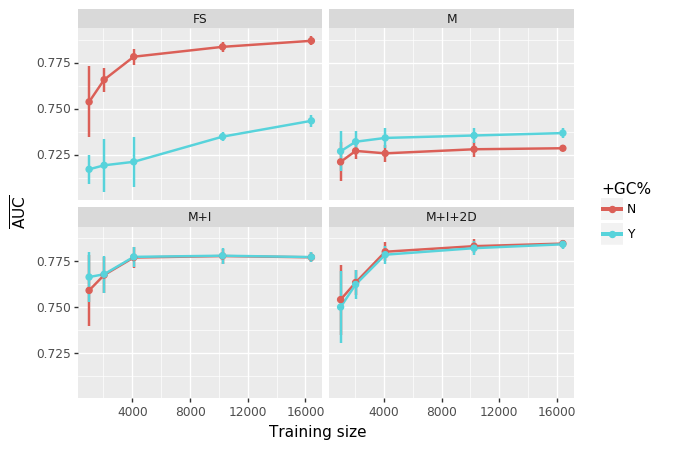

<ggplot: (-9223372036567876643)>


In [29]:
clfs = {'LR':'N', 'LR_GC':'Y'}
dims = [0, 1, 2, 6]

gc_lc_aucs = []
for dim in dims:
    data_dirs = glob.glob("classifier/results/chrom1/7-mer/data_ratio_1/direction_All/%s_way_samples/train_size_*/" % dim)
    for clf in clfs:
        sample_aucs = []
        for directory in data_dirs:
            aucs = get_auc(directory, sample_aucs, clf)
        sort_aucs = sorted(sample_aucs, key = lambda x: int(x[1]))
        
        for r in sort_aucs:
            dim = r[0]
            train_size = r[1]
            auc = float(r[2])
            gc = r[3]
            
            gc_lc_aucs.append([model_nm_dict[dim], train_size, auc, clfs[gc]])

models = set(r[0] for r in gc_lc_aucs)
train_sizes = set(r[1] for r in gc_lc_aucs)
gc_groups = set(r[3] for r in gc_lc_aucs)
n = 5
records = []
for model in models:
    for train_size in train_sizes:
        for gc in gc_groups:
            auc_list = []
            for r in gc_lc_aucs:
                if model not in r:
                    continue
                if train_size not in r:
                    continue
                if gc != r[3]:
                    continue
                auc_list.append(r[2])
            
            auc_mean = np.array(auc_list).mean()
            auc_se = np.array(auc_list).std(ddof=1)
            records.append([model, train_size, gc, auc_mean, auc_se])
    
h = ['Classifier', 'Training_size', '+GC%', 'Mean_AUC', 'Std_error']
gc_lc_tab = LoadTable(header=h, rows=records)
gc_lc_df = gc_lc_tab.to_pandas_df()
faceted_gc_lc = (ggplot(gc_lc_df) +
                aes(x="Training_size", y="Mean_AUC", colour='+GC%', group='+GC%') +
                geom_errorbar(aes(ymin="Mean_AUC-Std_error", ymax="Mean_AUC+Std_error"), width=.1, size=1) +
                geom_line(size=1) +
                geom_point(size=2) +
                labs(x="Training size", y="$\overline{\mathrm{AUC}}$") +
                facet_wrap(' ~ Classifier'))

outfig_name = "gc_vs_nogc_curve.pdf"
faceted_gc_lc.save("figs_n_tabs/%s" % outfig_name, units="cm", width=20, height=16)
print ("%s is saved!" % outfig_name)
print (faceted_gc_lc)

## Supp. figures: AUC scores comparison between the logistic regression classifier and the NB classifier - chrom1

M+I+2D_lr_v_nb_curve.pdf is saved!


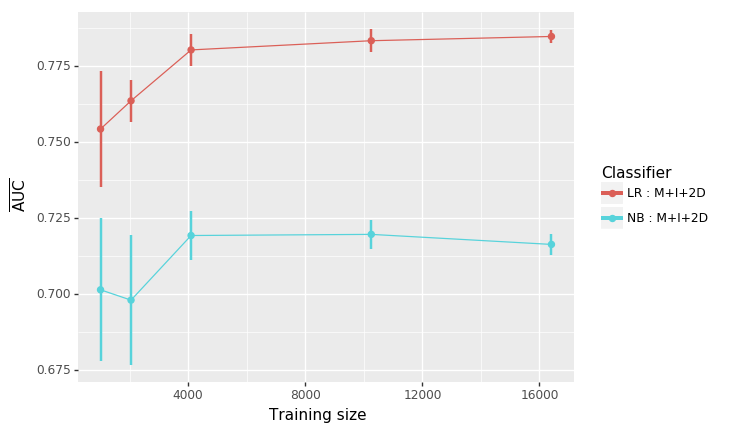

<ggplot: (-9223372036568678421)>


In [30]:
clfs = {'LR', 'NB'}

lr_v_nb_rows = []
data_dirs = glob.glob("classifier/results/chrom1/7-mer/data_ratio_1/direction_All/2_way_samples/train_size_*/")
    
for clf in clfs:
    sample_aucs = []
    for directory in data_dirs:
        aucs = get_auc(directory, sample_aucs, clf)
    sort_aucs = sorted(sample_aucs, key = lambda x: int(x[1]))
    for r in sort_aucs:
        dim = r[0]
        train_size = r[1]
        auc = float(r[2])
        classifier = r[3]
            
        lr_v_nb_rows.append([model_nm_dict[dim], train_size, auc, classifier])

models = set(r[0] for r in lr_v_nb_rows)
train_sizes = set(r[1] for r in lr_v_nb_rows)
clf_groups = set(r[3] for r in lr_v_nb_rows)
n = 5

chrom1_nb_dict = {}
for model in models:
    lr_v_nb_records = []
    for train_size in train_sizes:
        for clf in clf_groups:
            auc_list = []
            for r in lr_v_nb_rows:
                if model not in r:
                    continue
                if train_size not in r:
                    continue
                if clf not in r:
                    continue
                auc_list.append(r[2])
    
            auc_mean = np.array(auc_list).mean()
            auc_se = np.array(auc_list).std(ddof=1)
            clf_nm = '%s : %s'%(clf, model)
            
            chrom1_nb_dict[model] = auc_mean
            lr_v_nb_records.append([clf_nm, train_size, auc_mean, auc_se])
    
    lr_v_nb_h = ['Classifier', 'Training_size', 'Mean_AUC', 'Std_error']
    lr_v_nb_tab = LoadTable(header=lr_v_nb_h, rows=lr_v_nb_records)
    lr_v_nb_df = lr_v_nb_tab.to_pandas_df()
    fig_lr_v_nb = (ggplot(lr_v_nb_df) + 
                   aes(x="Training_size", y="Mean_AUC", colour="Classifier") +
                   geom_errorbar(aes(ymin="Mean_AUC-Std_error", ymax="Mean_AUC+Std_error"), width=.1, size=1) +
                   geom_line(size=0.5) +
                   geom_point(size=2) +
                   labs(x="Training size", y="$\overline{\mathrm{AUC}}$"))
    
    outfig_name = "%s_lr_v_nb_curve.pdf" % model
    fig_lr_v_nb.save("figs_n_tabs/%s" % outfig_name, units="cm", width=20, height=16)
    print ("%s is saved!" % outfig_name)
    print (fig_lr_v_nb)

#### Save all supplementary tables into a .tex file

In [31]:
with open("figs_n_tabs/supp_materials_tables.tex", "w") as out:
    out.write("\n\n".join(all_supp_tables))

## Figure plot learning curves for M+I model between k-mer samples with data from chromosome 1

   AUC_mean Classifier_design  Std_error  Train_size  k
0  0.768937               M+I   0.002508       16408  3
1  0.771855               M+I   0.002595       16408  5
2  0.777219               M+I   0.002822       16408  7
figs_n_tabs/long_flanks_AUC.pdf is saved!


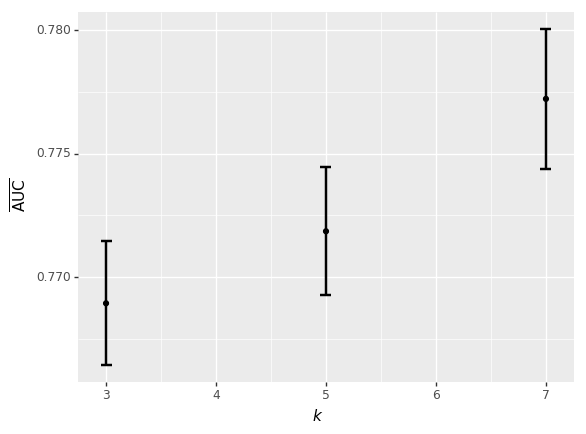

<ggplot: (-9223372036568454049)>


In [32]:
window_sizes = [3, 5, 7, 9, 17, 21, 41, 61, 81, 101]
train_sizes = [1009, 2050, 4101, 10255, 16408]

plot_rows = []
for ws in window_sizes:
    for ts in train_sizes:
        if ts != 16408:
            continue
        data_dirs = glob.glob("classifier/results/chrom1/%s-mer/data_ratio_1/direction_All/1_way_samples/train_size_%s/" % (ws, ts))
        for directory in data_dirs:
            aucs = get_auc(directory, [], 'LR')
            auc_list = [r[2] for r in aucs]
            auc_mean = np.array(auc_list).mean()
            auc_se = np.array(auc_list).std(ddof=1)
            plot_rows.append([model_nm_dict[1], ws, ts, auc_mean, auc_se])

plot_header = ['Classifier_design', 'k', 'Train_size', 'AUC_mean', 'Std_error']
long_flanks_tab = LoadTable(header=plot_header, rows=plot_rows).to_pandas_df()
print (long_flanks_tab)
long_flanks_plot = (ggplot(long_flanks_tab) +
                aes(x='k', y='AUC_mean') + 
                geom_errorbar(aes(ymin="AUC_mean-Std_error", ymax="AUC_mean+Std_error"), width=.1, size=1) +
                geom_point() + 
                labs(x="$k$", y="$\overline{\mathrm{AUC}}$"))

outname = "figs_n_tabs/long_flanks_AUC.pdf"    
long_flanks_plot.save(outname, units="cm", width=20, height=15)
print ("%s is saved!" % outname)
print (long_flanks_plot)